# Group Project: How do various musical elements correlate to the number of Spotify streams?
#### Xuyang Chen, Rachel Weng, Martin Wong, Seabert Yuan
### Overview

Spotify is a digital music streaming service that allows users to access millions of songs on various devices, including computers, phones, and cars. As of 2024, Spotify is documented as the world’s most popular streaming service, with 350 million active users and 150 million premium subscribers. [(Source)](https://www.cnn.com/cnn-underscored/reviews/best-music-streaming-service#:~:text=Spotify%20is%20the%20most%20popular,users%20and%20150%20million%20subscribers.)

Our project aims to answer the following question: How does danceability, valence, beats-per-minute, and Spotify chart rankings correlate to the number of Spotify streams?
The dataset, from Kaggle, documents the most streamed Spotify songs of 2023 obtained using the Spotify API and provides an abundance of information about both the song’s background and musicality. A stream is defined by a user listening to a song for more than 30 seconds. The dataset also provides percentage values from a range of 0 - 100 % of danceability and valence. Danceability is a track’s suitability for dancing based on musical factors such as tempo, beat strength, rhythmic stability, and overall regularity. Valence describes a track’s musical positiveness; Spotify does not outline how valence is calculated. Spotify chart rankings are calculated by the number of recent streams and shares. 

## Preliminary exploratory data analysis:

In [1]:
library(tidyverse)
library(tidymodels)
library(reshape2)
library(repr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Reading the data from the web into R 

In [2]:
spotify_data <- read_csv("https://raw.githubusercontent.com/martin0wong/dsci100_project/main/data/spotify-2023.csv")
spotify_data

Rows: 953 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (5): track_name, artist(s)_name, streams, key, mode
dbl (17): artist_count, released_year, released_month, released_day, in_spot...
num  (2): in_deezer_playlists, in_shazam_charts

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


track_name                                                                                   
1   Seven (feat. Latto) (Explicit Ver.)                                                          
2   LALA                                                                                         
3   vampire                                                                                      
4   Cruel Summer                                                                                 
5   WHERE SHE GOES                                                                               
6   Sprinter                                                                                     
7   Ella Baila Sola                                                                              
8   Columbia                                                                                     
9   fukumean                                                                                     
10  La Bebe - Remix                                                                              
11  un x100to                                                                                    
12  Super Shy                                                                                    
13  Flowers                                                                                      
14  Daylight                                                                                     
15  As It Was                                                                                    
16  Kill Bill                                                                                    
17  Cupid - Twin Ver.                                                                            
18  What Was I Made For? [From The Motion Picture "Barbie"]                                      
19  Classy 101                                                                                   
20  Like Crazy                                                                                   
21  LADY GAGA                                                                                    
22  I Can See You (Taylorï¿½ï¿½ï¿½s Version) (From The                                           
23  I Wanna Be Yours                                                                             
24  Peso Pluma: Bzrp Music Sessions, Vol. 55                                                     
25  Popular (with Playboi Carti & Madonna) - The Idol Vol. 1 (Music from the HBO Original Series)
26  SABOR FRESA                                                                                  
27  Calm Down (with Selena Gomez)                                                                
28  MOJABI GHOST                                                                                 
29  Last Night                                                                                   
30  Dance The Night (From Barbie The Album)                                                      
⋮   ⋮                                                                                            
924 we fell in love in october                                                                   
925 2 Be Loved (Am I Ready)                                                                      
926 Celestial                                                                                    
927 Typa Girl                                                                                    
928 I Really Want to Stay at Your House                                                          
929 California Breeze                                                                            
930 Bamba (feat. Aitch & BIA)                                                                    
931 Casei Com a Putaria                                                                          
932 Major Distribution                                                              

### Cleaning and wrangling data into a tidy format.

In [3]:
colnames(spotify_data) <- c("track_name", "artist(s)_name", "artist_count", "released_year", "released_month", "released_day", 
                                    "in_spotify_playlists", "in_spotify_charts", "streams", "in_apple_playlists", "in_apple_charts", 
                                    "in_deezer_playlists", "in_deezer_charts", "in_shazam_charts", "bpm", "key", "mode", 
                                    "danceability_percent", "valence_percent", "energy_percent", 
                                    "acousticness_percent", "instrumentalness_percent", "liveness_percent", "speechiness_percent")
spotify_data_wrangled <- spotify_data |>
                         #avg days in a year/month searched from web
                         mutate(days_released = round((2023-released_year)*365.25 + released_month*30.436875 + released_day, 0)) |> 
                         mutate(key = recode(key, "C#" = "1", "D" = "2", "D#" = "3", "E" = "4", "F" = "5", "F#" = "6", 
                                                 "G" = "7", "G#" = "8", "A" = "9", "A#" = "10", "B" = "11")) |>
                         mutate(mode = recode(mode, "Minor" = "1", "Major" = "2")) |>
                         mutate(across(streams:mode, as.numeric)) |>
                         mutate(streams = streams/1000000) |>
                         drop_na() |>
                         #selecting all columns with numeric values for regression, removing released_xxx columns as wrangled into days_released
                         select(artist_count, in_spotify_playlists:days_released)
spotify_data_wrangled

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(streams:mode, as.numeric)`.
Caused by warning:
! NAs introduced by coercion”


artist_count in_spotify_playlists in_spotify_charts streams   
1   2             553                 147                141.38170
2   1            1474                  48                133.71629
3   1            1397                 113                140.00397
4   1            7858                 100                800.84082
5   1            3133                  50                303.23632
6   2            2186                  91                183.70623
7   2            3090                  50                725.98011
8   1             714                  43                 58.14938
9   1            1096                  83                 95.21731
10  2            2953                  44                553.63407
11  2            2876                  40                505.67144
12  1             422                  55                 58.25515
13  1            3528                  98                387.57074
14  1            8109                  77               1163.09365
15  1            2942                  77                496.79569
16  2            2610                  40                335.22223
17  1             596                  68                363.36974
18  3             332                  26                 86.44484
19  1             516                  38                 52.13525
20  2            1313                  40                200.64722
21  3            1945                  87                115.36456
22  1             250                  26                 78.30065
23  2            7112                  77                899.18338
24  2             859                  40                 61.24529
25  1            2420                  19                429.82981
26  1            2988                 101                127.40895
27  1             864                  78                 22.58116
28  2             266                  34                 52.29427
29  3            6036                  88                843.95751
30  1            9082                  56                999.74828
⋮   ⋮            ⋮                    ⋮                 ⋮         
787 4             836                  0                159.24067 
788 1             430                  6                170.70958 
789 1            2020                  0                154.35696 
790 1            6858                  0                723.04385 
791 1            3682                  6                247.68912 
792 1            1639                  0                176.47491 
793 1             452                 10                235.54929 
794 1             991                  0                 85.55936 
795 3             869                  7                146.22349 
796 3             648                  4                187.70159 
797 2            1545                  0                154.86315 
798 3            1930                  0                191.33366 
799 1            1948                  0                253.65085 
800 1            1608                  0                223.06427 
801 2            1338                  0                170.41388 
802 1            1936                  0                218.32059 
803 2            1794                  0                141.72100 
804 2            1652                  2                198.36554 
805 1            1715                  0                177.50392 
806 2             486                  0                 71.09571 
807 2            1007                  0                112.43640 
808 1             481                  9                203.43647 
809 1            1045                  0                 93.36754 
810 2            1060                  0                106.24922 
811 1            1274                  0                181.38259 
812 1             953                  0                 91.47336 
813 1            1180                  0                121.87187 
814 2             573                  0           

### Using only training data, summarize the data in at least one table (this is exploratory data analysis).

We selected the columns in_apple_charts, bpm, danceability_percent and valence_percent as predictors for our regression model on streams.

In [4]:
spotify_split <- initial_split(spotify_data_wrangled, prop = 0.75, strata = streams)
spotify_train <- training(spotify_split)
spotify_test <- testing(spotify_split)

spotify_summary <- merge(spotify_train |> group_by(key) |> summarize(across(in_spotify_playlists:bpm ,mean)),
                         spotify_train |> group_by(key) |> summarize(across(danceability_percent:days_released ,mean)))
spotify_summary

artist_count in_spotify_playlists in_spotify_charts streams  
1   1             714                 43                 58.14938
2   1            1096                 83                 95.21731
3   1             422                 55                 58.25515
4   3             332                 26                 86.44484
5   1             516                 38                 52.13525
6   3            1945                 87                115.36456
7   1             250                 26                 78.30065
8   2             859                 40                 61.24529
9   1             864                 78                 22.58116
10  3            1298                 38                107.75385
11  2             731                 15                111.94766
12  1             410                 36                 14.78042
13  1             148                 24                 39.57818
14  2            1004                 35                 54.26610
15  1             370                 20                 43.85763
16  2             267                  9                 39.70909
17  1             139                 17                 39.22893
18  1             804                 25                 95.13200
19  1              31                 39                 38.41196
20  1            2000                 46                127.56754
21  1             674                 47                118.48235
22  1              77                 35                 29.56222
23  1             266                 27                 77.30961
24  2              58                 18                 39.05856
25  3            1094                 34                 90.83975
26  2             201                 11                 55.84235
27  2             871                 32                 66.90250
28  1             451                 33                 96.27375
29  2             293                  8                 11.95664
30  3             727                 16                 94.18647
⋮   ⋮            ⋮                    ⋮                 ⋮        
583 1            29499                11                 822.2397
584 1            30427                 7                1202.7227
585 2            19067                 0                 675.0395
586 1            33206                 1                1929.7703
587 2            17115                 0                 918.9154
588 2             6955                 0                1180.8963
589 1            33032                 0                2280.5661
590 2            15010                 2                2484.8129
591 1            13454                 1                1439.1914
592 2             4890                20                 759.2088
593 2             6111                 4                 756.9080
594 1             3659                 0                1200.8085
595 1             9833                 0                 797.1961
596 1            50887                34                1970.6733
597 1             3257                 0                 665.7656
598 2            23375                21                2204.0807
599 2            28032                 0                2591.2243
600 1             8737                 0                 694.5253
601 1            11985                 0                 924.1933
602 1             7556                 0                1023.1871
603 1             8429                 1                 807.0159
604 1             9021                 0                 723.8945
605 2             9539                15                1304.3140
606 1            13101                 9                1284.9426
607 1            10211                 0                1122.3644
608 1             6080                 0                 704.1711
609 1            17504                34                 887.9061
610 1            19806                 7                 703.3017
611 1            10826                 4    

### Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis).

We first plot all columns on the x axis and the number of streams on spotify on the y-axis to visualize how relevant would the other variables be compared to the number of streams.

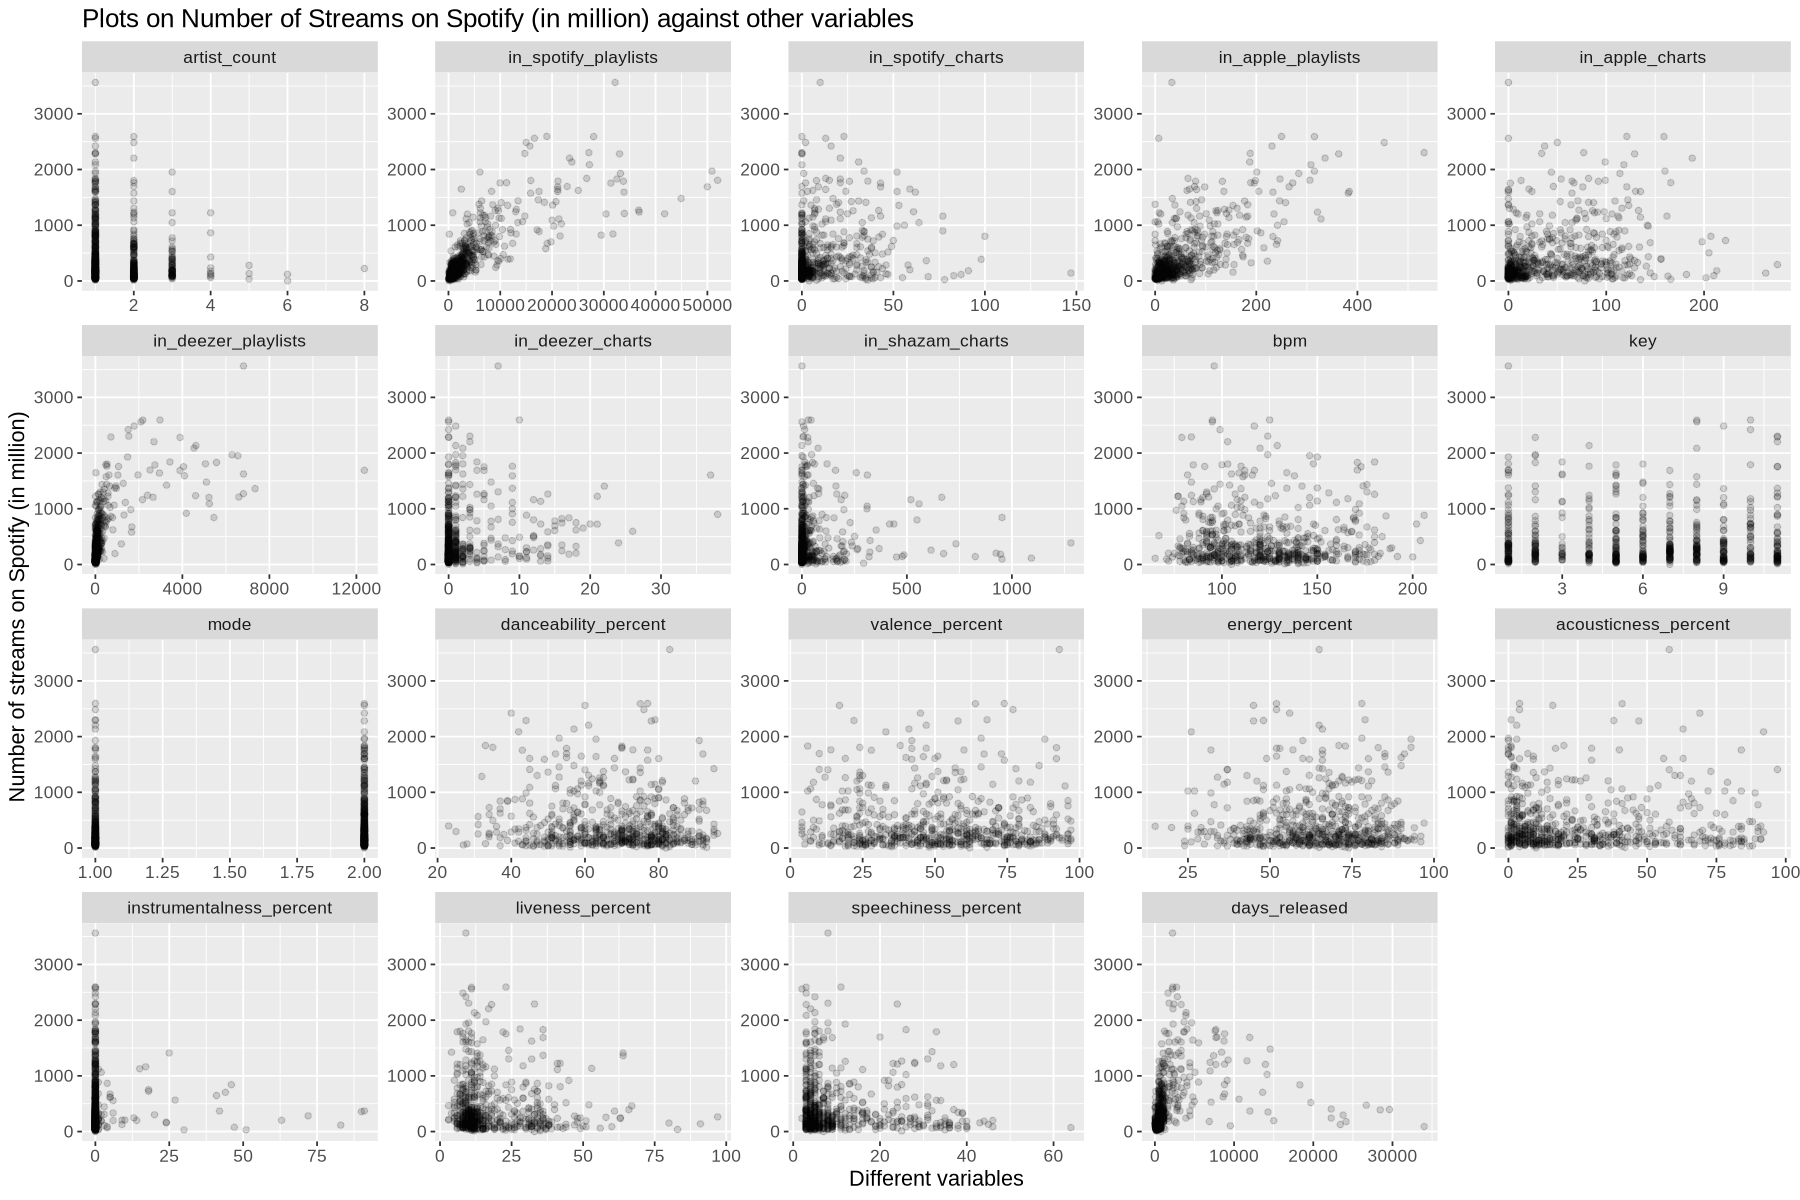

In [7]:
options(repr.plot.height = 10, repr.plot.width = 15)
spotify_train_plot <- spotify_train |> melt("streams")

ggplot(spotify_train_plot, aes(value, streams)) + 
  geom_point(alpha = 0.1) + 
  labs(x = "Different variables", y = "Number of streams on Spotify (in million)", 
       title = "Plots on Number of Streams on Spotify (in million) against other variables") +
  theme(text = element_text(size = 14)) +
  facet_wrap(~variable, scales = "free")

### Methods:

Upon conducting preliminary exploratory data analysis, the four following variables were selected as predictors to predict the number of streams:
- Danceability, to determine if people are more likely to enjoy songs that they can   directly engage with
- Valence, to determine whether people enjoy songs that are more musically            positive/happy in their daily life
- Bpm, to determine if people are more likely to enjoy faster songs
- Apple charts: This variable was selected to analyze whether this data is            applicable to a wider audience range, encompassing Apple listeners to see if        trends are true of other platforms in predicting the number of Spotify streams.
- Variables such as “instrumentalness”, “liveness”, and “speechiness” were not        included in our analysis as they had an uneven distribution of points, with an      overwhelming number of 0 values in the range of 0-100.

We will visualize the results by creating a scatter plot and its predicted regression line with one graph for each predictor. The y-axis will be the # of streams, and the x-axis will be the predictor. 


### Expected outcomes and significance:

Based on exploratory analysis and previous trends, we expect to find songs with moderately high bpm (90-150), high danceability, and moderately high valence percentages to show a correlation with increased Spotify streams

By finding trends in songs people enjoy and connect to, we can study the emotional and cultural effects of music on society and how it shapes mood, shifts perceptions, and sparks motivation and inspiration. Our findings can also help artists create popular songs and improve streaming services by helping streaming platforms recommend songs to users.

Further questions from the data analysis include:
- How do song lyrics impact the popularity of songs?
- Why do people generally enjoy faster songs?
- Which songs are appropriate and preferred for certain occasions such as parties,    sports, or casual listening?
- How might the musical attributes of the most streamed songs shift over time?
